In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import sys
sys.path.append('/content/gdrive/MyDrive/AIMS-code/GitHub')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from utils.plotting.two_dimensional import *
from utils.calculate_quantities import calculate_quantities
from utils.estimate_z_using_mc import estimate_z_using_mc

from hamiltonians.two_dimensional import NormalisedHarmonicPotential, HarmonicPotential, GMMPotential, DifficultGMMPotential
from kernels.overdamped_kernel import OverdampedKernel

from sis.sample import sample
from sis.protocols import InterpolationProtocol
from sis.protocols import LearnableInterpolationProtocol, LearnableProtocol, FullyLearnableProtocol
from sis.weight_calculators import AISLogWeightsCalculator


# Define the target and initial distribution


In [5]:
# Experimetn parameters
n_samples = 10000
n_steps = 100

device = "cpu"

In [6]:
# Define initial distribution (tractable)
f_0 = NormalisedHarmonicPotential(torch.tensor([0., 0.], device=device), torch.eye(2, device=device))

# Define target distribution (intractable)
# f_T = NormalisedHarmonicPotential(torch.tensor([0., 0.], device=device), torch.eye(2, device=device))
# f_T = HarmonicPotential(torch.tensor([3., 3.], device=device))
# f_T = GMMPotential(device=device)
f_T = DifficultGMMPotential(device=device)
beta = 1. # This is the inverse temperature of the target

# We use this for all experiments (for now)
AIS_forward_kernel = OverdampedKernel(beta, 0.01, device=device)
AIS_weights_calculator = AISLogWeightsCalculator()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Z is 1.0069892406463623


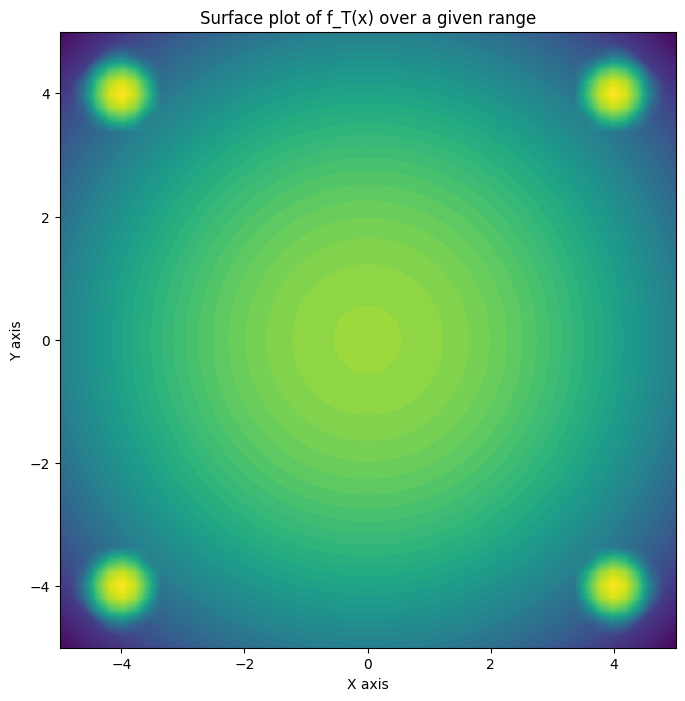

In [7]:
Z = estimate_z_using_mc(f_T, beta, [-10, -10], [20, 20], samples=10000000, device=device)
print('Z is %s' %(Z))
plot_f_T(f_T, -5, 5, device=device)

/content/gdrive/MyDrive/AIMS-code/GitHub/sis/protocols.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=self.device)


Average Work: -1.61
Variance of Work: 0.00
Normalizing Constant Estimate: 0.20
Variance of Normalizing Constant Estimate: 0.00


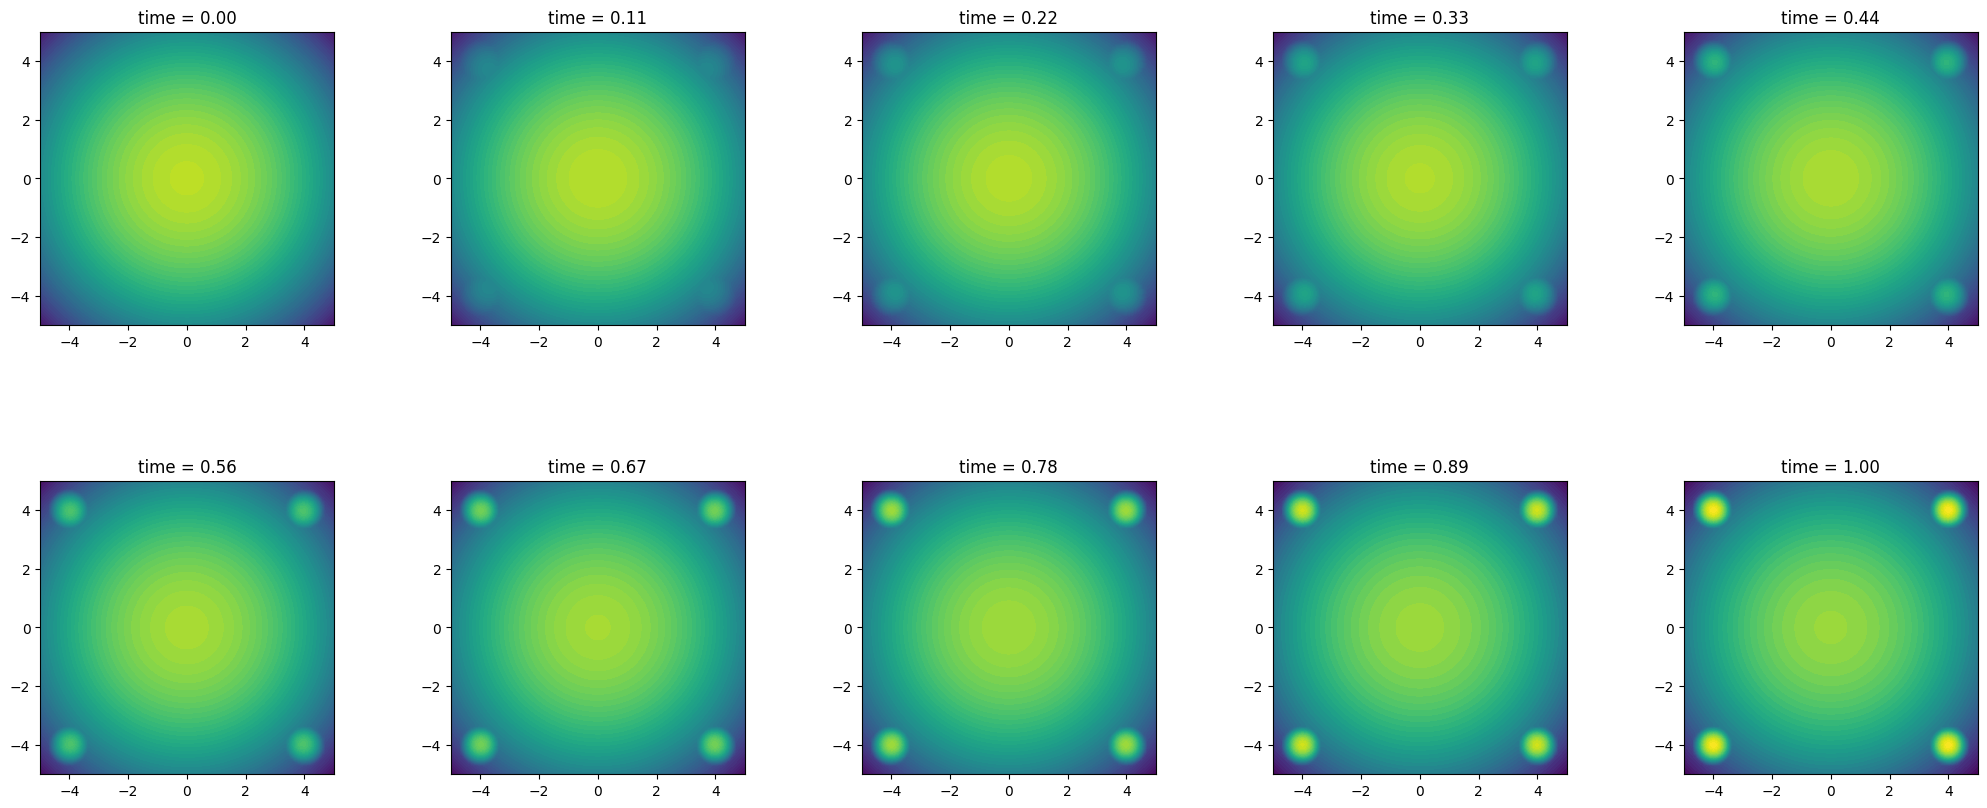

In [8]:
#Setup interpolation_protocol for comparison
interpolation_protocol = InterpolationProtocol(f_0, f_T, device)

AIS_history = sample(f_0, interpolation_protocol, AIS_forward_kernel, AIS_weights_calculator, n_samples, n_steps)

calculate_quantities(AIS_weights_calculator)
# plot_beta(interpolation_protocol)
plot_protocol(interpolation_protocol, beta, device=device)
# plot_animation(interpolation_protocol, AIS_history, device=device)

# Learnable Protocol

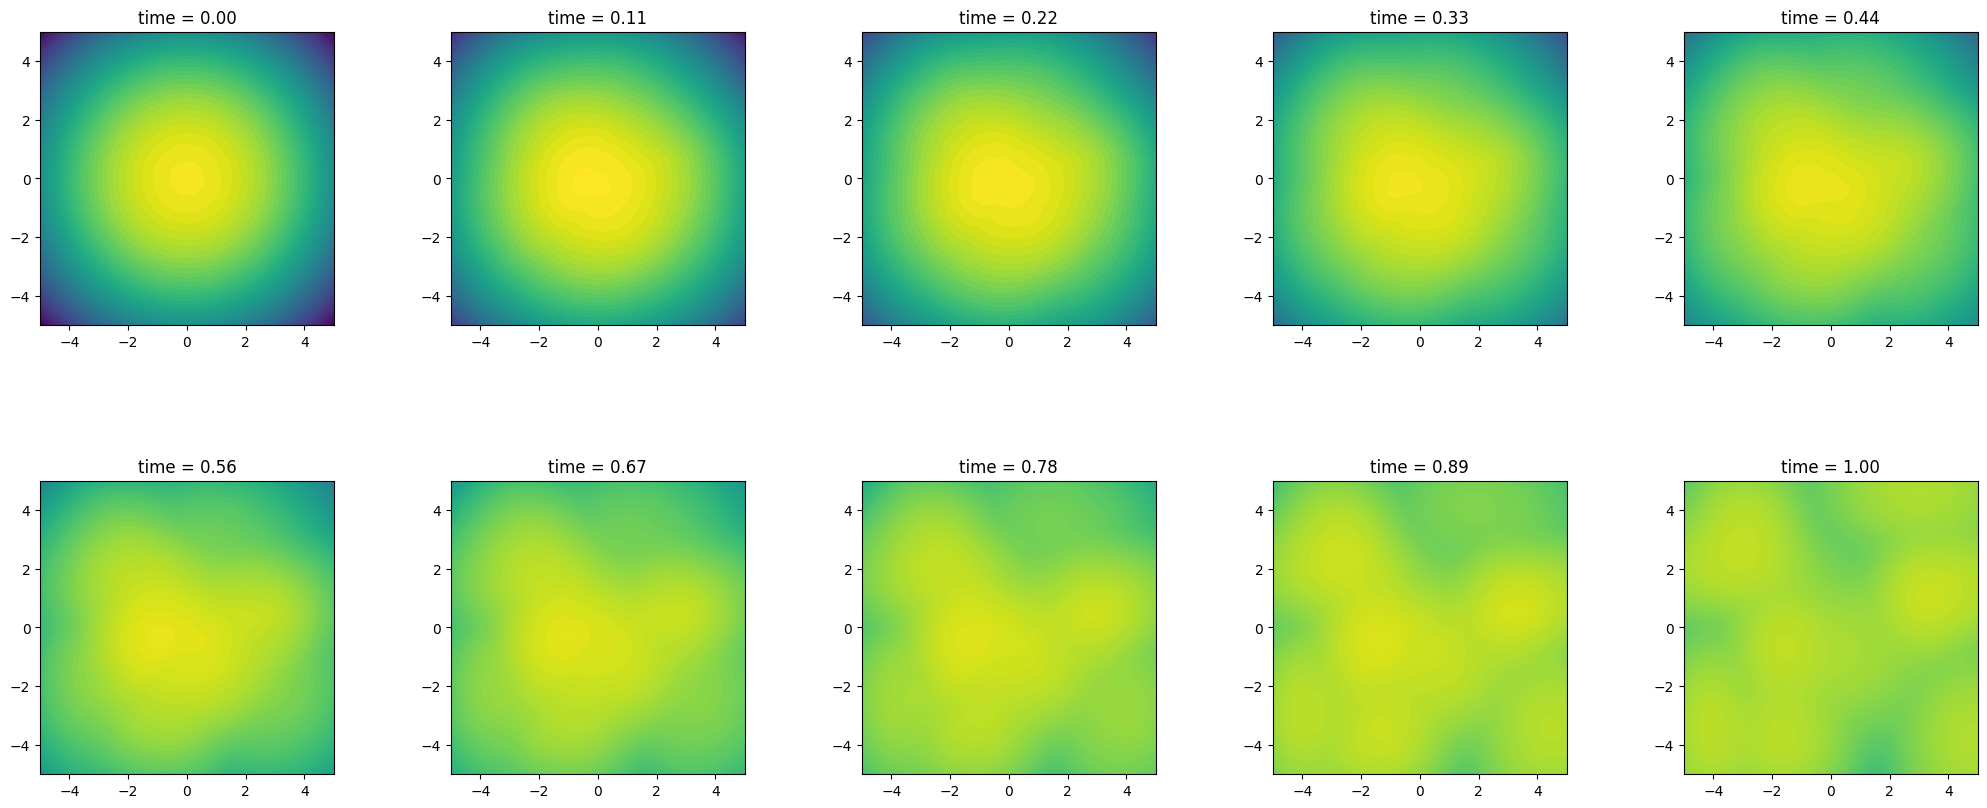

In [ ]:
from sis.protocols import LearnableProtocol

# Try different numbers of layers
# Try different architectures
# Try differen time embeddings

class EBM(nn.Module):
    def __init__(self):
        super(EBM, self).__init__()
        self.EBM = nn.Sequential(
            nn.Linear(3, 32),  # Adjusted for an additional input dimension (time)
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def __call__(self, x, t):
        t_tensor = torch.full((x.shape[0], 1), fill_value=t, device=x.device, dtype=x.dtype)
        xt = torch.cat((x, t_tensor), dim=1)

        ebm_output = self.EBM(xt).view(-1) * 10
        return ebm_output


ebm = EBM()
# protocol = FullyLearnableProtocol(f_0, f_T, ebm)
protocol = LearnableProtocol(f_0, f_T, ebm)
# protocol = LearnableInterpolationProtocol(f_0, f_T, device=device)
protocol.to(device)
plot_protocol(protocol, beta, device=device)

In [ ]:
from sis.learn_protocol import learn_protocol

# Try different learning rates
# Try to fit as many samples on the GPU as possible (Don't change n_samples, we want this to be consisten)
# Try running it for longer≠≠≠

AIS_weights_calculator.reset()
learn_protocol(f_0, protocol, AIS_forward_kernel, AIS_weights_calculator, 3000, n_steps, 50, lr=0.01)

Z:0.73, loss:87.09: 100%|██████████| 50/50 [03:13<00:00,  3.86s/it]


Average Work: -1.70
Variance of Work: 0.98
Normalizing Constant Estimate: 0.53
Variance of Normalizing Constant Estimate: 43.71


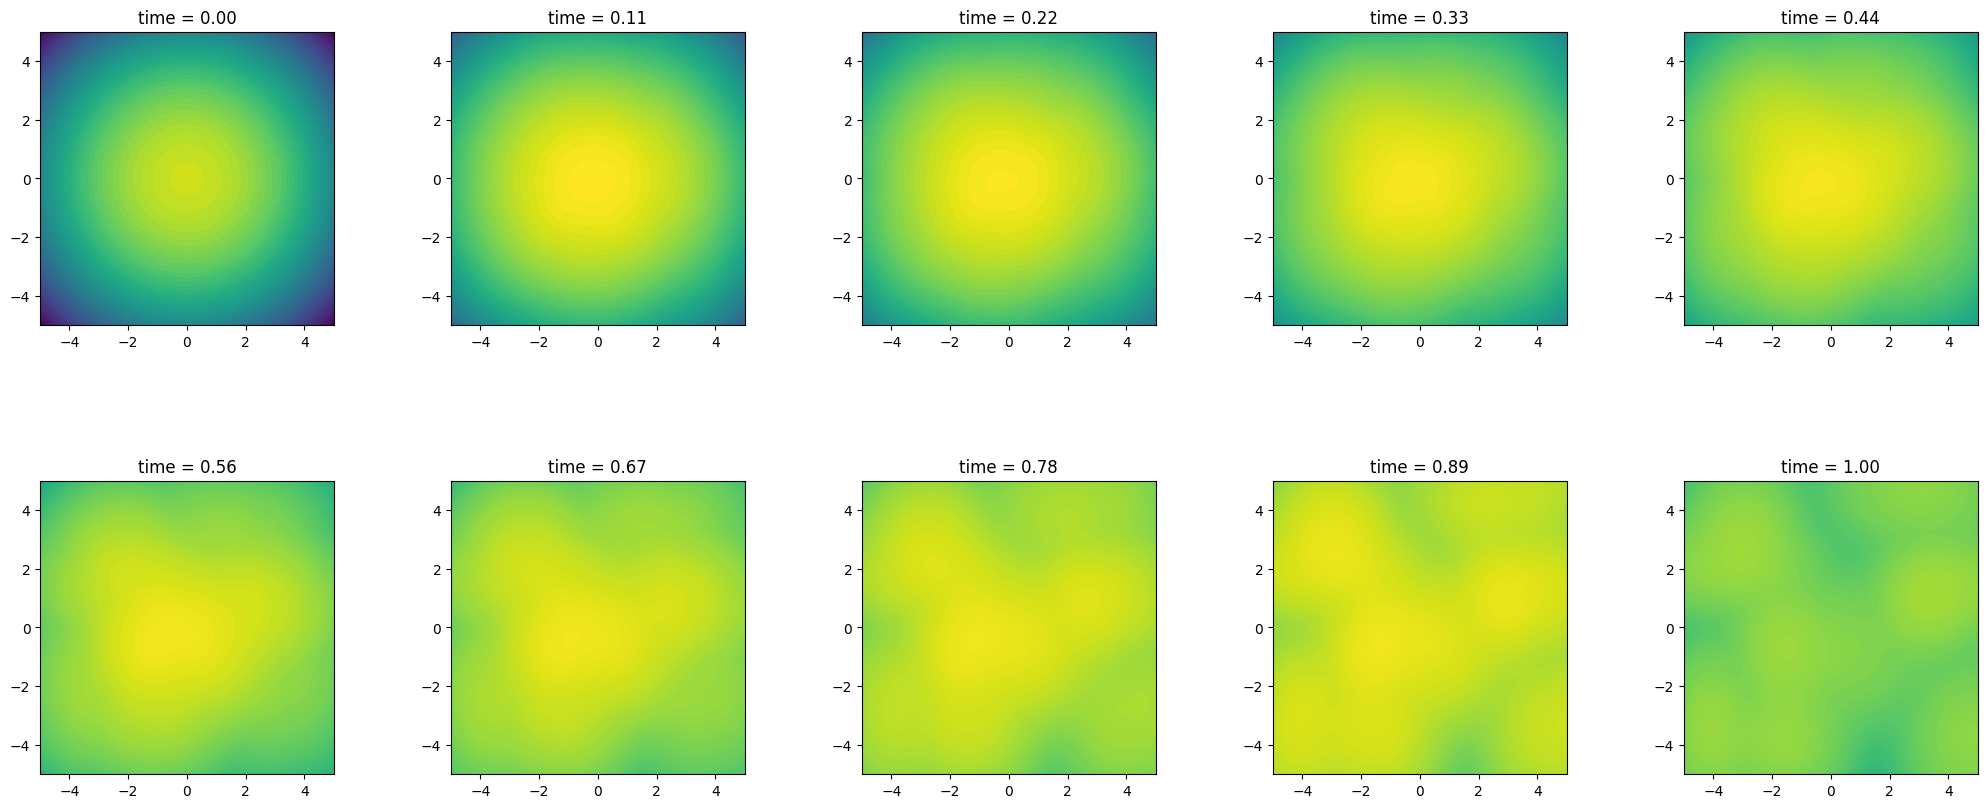

In [ ]:
AIS_weights_calculator.reset()
full_history = sample(f_0, protocol, AIS_forward_kernel, AIS_weights_calculator, n_samples, n_steps)

calculate_quantities(AIS_weights_calculator)
# plot_beta(protocol, device=device)
plot_protocol(protocol, beta, device=device)
# plot_animation(protocol, full_history, device=device)

# Add extra eval / validation?